## Start Feature Extraction from the collected Dataset

In [1]:
import os
import pandas as pd
import librosa

import numpy as np
import matplotlib.pyplot as plt

os.chdir('../')

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from plot_helper import PlotHelp
from real_time_inference import RecordThread

In [4]:
file_path = "data//external//processed//"
meta_data = pd.read_csv("data//meta_data.csv")

In [5]:
## if this doesn't hold .. some deep problem we gotta fix my myan
assert all(meta_data.start_time.isna() == meta_data.end_time.isna())

In [6]:
meta_data['label'] = ~meta_data.start_time.isna()
meta_data['label'] = meta_data['label'].astype(int) 

In [7]:
def get_melspectrogram_db(file_path, sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [8]:
def norm_spec(spec):
    return (spec - spec.min()) / (spec.max() - spec.min())

In [9]:
plot_help = PlotHelp()

## Check the Traning Example Visually  

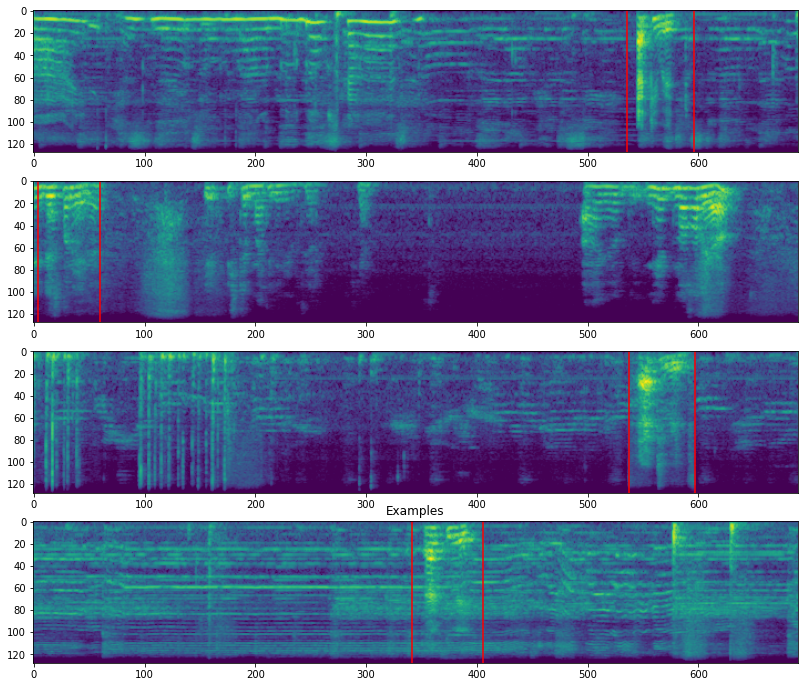

In [10]:
train_path = 'data/external/processed/train'
test_path = 'data/external/processed/test'

meta_data_train = meta_data[:1701]
meta_data_test = meta_data[1701:]

pos_examples = meta_data_train[meta_data_train.label == 1].sample(4)
neg_examples = meta_data_train[meta_data_train.label == 0].sample(4)

mel_spec_pos = [ get_melspectrogram_db( os.path.join( train_path , pos_example.filename ) , 44100  )  for _,pos_example in pos_examples.iterrows() ]
mel_spec_pos_norm = [ norm_spec(i) for i in mel_spec_pos ]

mel_spec_neg = [ get_melspectrogram_db( os.path.join( train_path , neg_example.filename ) , 44100  ) for _,neg_example in neg_examples.iterrows() ]
mel_spec_neg_norm = [ norm_spec(i) for i in mel_spec_neg ]

mel_scale_max = mel_spec_pos[0].shape[1]
time_scale_max = 8000 ## ms

potential_range_in_freq_domain = [  ( mel_scale_max * pos_example.start_time / time_scale_max , 
                                      mel_scale_max * pos_example.end_time / time_scale_max) 
                                      for _,pos_example in pos_examples.iterrows()]


plot_help.plot_examples(mel_spec_pos_norm , potential_range_in_freq_domain  )

In [11]:
mel_spec_neg_norm[0].shape

(128, 690)

In [12]:
from pydub.playback import play
from pydub import AudioSegment

## Check one such example for Verification
pos_sound = AudioSegment.from_wav(os.path.join( train_path , pos_examples.iloc[2].filename ))
neg_sound = AudioSegment.from_wav(os.path.join( train_path , neg_examples.iloc[0].filename ))

def check_example(sound):

    ## playing positive example
    print('Playing ...')
    play( sound )
    print('Playing Stopped')

check_example(pos_sound)

Playing ...
Playing Stopped


## Sanity Check : Take in an audio input and take a look at spectrogram 

In [13]:
# ## my personal recording
# import time
# record = RecordThread('sample_record.wav', 8)
# record.start()
# time.sleep(0.2)
# record.stoprecord()

# print(get_melspectrogram_db( 'inference_0.wav' , 44100  ).shape)

# plot_help.plot_examples( [norm_spec(get_melspectrogram_db( 'inference_0.wav' , 44100  ))] )

## Working with Audio Dataloaders and Transformations

In [14]:
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [15]:
meta_data[:1701].shape , meta_data[1701:].shape

((1701, 4), (299, 4))

In [16]:
class AudioLoader(Dataset):
    def __init__(self, meta_data, transform=None, mode="train"):
        # setting directories for data
        data_root = "data/external/processed"
        self.mode = mode
        if self.mode is "train":
            self.data_dir = os.path.join(data_root, "train")
            self.csv_file = meta_data_train
            
        elif self.mode is "test":
            self.data_dir = os.path.join(data_root, "test")
            self.csv_file = meta_data_test
        
        self.transform = transform
        
    def __len__(self):
        return self.csv_file.shape[0] 

    def __getitem__(self, idx):
        filename = self.csv_file["filename"].iloc[idx]
        file_path = os.path.join( self.data_dir, filename )

        data,sr = librosa.load(file_path,sr=44100)

        if self.transform is not None:
            data = self.transform(data)

        label = self.csv_file["label"].iloc[idx]
        return data, label

In [17]:
audio_transformation = transforms.Compose([
        lambda x: librosa.feature.melspectrogram(x, sr=44100, n_fft=2048,
                    hop_length=512,n_mels=128,fmin=20,fmax=8300), # MFCC 
        lambda x : librosa.power_to_db(x,top_db=80),
        lambda x : norm_spec(x),
        lambda x :  x.reshape( 1 , 128 , 690 )
        # lambda x: Tensor(x)
        ])

# todo: multiprocessing, padding data
trainloader = DataLoader(
    AudioLoader(meta_data=meta_data_train, transform=audio_transformation, mode="train"), 
    batch_size=32,
    shuffle=True, 
    num_workers=0)

# todo: multiprocessing, padding data
testloader = DataLoader(
    AudioLoader(meta_data=meta_data_test, transform=audio_transformation, mode="test"), 
    batch_size=32,
    shuffle=True,
    num_workers=0)

## Model Building

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3) ## inchannel , outchannel , kernel size ..
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv1_bn = nn.BatchNorm2d(8)

        self.drp = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool2 = nn.MaxPool2d(4, stride=2)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv3_bn = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32 * 12 * 82, 32)
        self.fc2 = nn.Linear(32, 1)


    def forward(self, x):
        x = self.conv1_bn(self.pool1(F.relu(self.conv1(x))))
        x = self.drp(x)

        x = self.conv2_bn(self.pool1(F.relu(self.conv2(x))))
        x = self.drp(x)

        x = self.conv3_bn(self.pool2(F.relu(self.conv3(x))))
        x = self.drp(x)
        # x = self.drp(self.pool1(F.relu(self.conv4(x))))
        # x = self.drp(self.pool2(F.relu(self.conv5(x))))
        #size = torch.flatten(x).shape[0]
        x = x.view(-1, 32 * 12 * 82)
        #x = x.unsqueeze_(1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
# device = 'cpu'

In [36]:
# defining the model
model = Net().to(device)
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters())
# defining the loss function
criterion = nn.BCELoss().to(device)
# checking if GPU is available
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drp): Dropout2d(p=0.1, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=31488, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


## Training the model

In [63]:
for epoch in range(50):  # loop over the dataset multiple times

    model.train()
    running_loss = 0.0
    training_acc = []
    val_acc = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.unsqueeze(1)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.type_as(outputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        training_acc.append( calc_accuracy( outputs, labels ) )

        if i %  10 == 0 :    #
            curr_training_loss = sum(training_acc)/len(training_acc)
            print( f'At {i+1}th iter, Epoch {epoch+1} :  Loss accumulated upto : {running_loss} || Running Train Accuracy : {curr_training_loss}' )
        
    model.eval()
    val_loss = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.unsqueeze(1)
        output_val = model(inputs)

        labels = labels.type_as(outputs)note
        loss_val = criterion(output_val, labels)

        val_loss += loss_val.item()
        val_acc.append( calc_accuracy( output_val, labels ) )

    curr_training_loss = sum(training_acc)/len(training_acc)
    curr_val_loss = sum(val_acc)/len(val_acc)

    print(f'After Epoch {i+1} : Training Loss {running_loss} || Validation loss {val_loss}')
    print(f'Training Accuracy {curr_training_loss} || Validation Accuracy {curr_val_loss}')

print('Finished Training . now saving ')
torch.save(model.state_dict(), 'my_dummy_model')

o : 16.41686123609543 || Running Train Accuracy : 0.7227822580645161
At 41th iter, Epoch 6 :  Loss accumulated upto : 21.036492556333542 || Running Train Accuracy : 0.739329268292683
At 51th iter, Epoch 6 :  Loss accumulated upto : 26.344968527555466 || Running Train Accuracy : 0.7359068627450981
After Epoch 10 : Training Loss 27.86290618777275 || Validation loss 6.121852844953537
Training Accuracy 0.7393518518518518 || Validation Accuracy 0.7036931818181819
At 1th iter, Epoch 7 :  Loss accumulated upto : 0.37900370359420776 || Running Train Accuracy : 0.84375
At 11th iter, Epoch 7 :  Loss accumulated upto : 4.5654556453228 || Running Train Accuracy : 0.7784090909090909
At 21th iter, Epoch 7 :  Loss accumulated upto : 8.938916355371475 || Running Train Accuracy : 0.7961309523809523
At 31th iter, Epoch 7 :  Loss accumulated upto : 13.200575798749924 || Running Train Accuracy : 0.7883064516129032
At 41th iter, Epoch 7 :  Loss accumulated upto : 17.588265031576157 || Running Train Accurac

KeyboardInterrupt: 

In [59]:
def calc_accuracy( outputs, labels ):
    total_examples = len(outputs)
    correct_pred = torch.sum((outputs >= 0.5) == labels).to('cpu').item()
    return correct_pred/ total_examples